# **Libraries**

In [254]:
import pandas as pd
import numpy as np
from numpy import nan
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style

from xgboost import plot_importance, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
import xgboost as xgb

# **Data Analysis**

### Load data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Assignments/Machstatz/trainingData.csv')

### Explore data and check some statistics


In [ ]:
df.shape

(40000, 21)

In [ ]:
df.columns

Index(['Id', 'city', 'age', 'sex', 'social_class', 'primary_business',
       'secondary_business', 'annual_income', 'monthly_expenses',
       'old_dependents', 'young_dependents', 'home_ownership', 'type_of_house',
       'occupants_count', 'house_area', 'sanitary_availability',
       'water_availabity', 'loan_purpose', 'loan_tenure', 'loan_installments',
       'loan_amount'],
      dtype='object')

In [ ]:
df.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,2,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,1,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,2,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,2,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,0,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


In [ ]:
set(df.dtypes.tolist())

{dtype('int64'), dtype('float64'), dtype('O')}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     40000 non-null  int64  
 1   city                   38136 non-null  object 
 2   age                    40000 non-null  int64  
 3   sex                    40000 non-null  object 
 4   social_class           34745 non-null  object 
 5   primary_business       39974 non-null  object 
 6   secondary_business     34759 non-null  object 
 7   annual_income          40000 non-null  float64
 8   monthly_expenses       39880 non-null  float64
 9   old_dependents         40000 non-null  int64  
 10  young_dependents       40000 non-null  int64  
 11  home_ownership         39621 non-null  float64
 12  type_of_house          39306 non-null  object 
 13  occupants_count        40000 non-null  int64  
 14  house_area             40000 non-null  float64
 15  sa

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,40000.0,20000.500000,11547.149720,1.0,10000.75,20000.5,30000.25,40000.0
age,40000.0,55.159900,3830.355660,2.0,29.00,35.0,42.00,766105.0
annual_income,40000.0,37640.214425,28739.116481,0.0,14400.00,36000.0,56000.00,1200000.0
monthly_expenses,39880.0,3810.875401,4592.958009,2.0,2500.00,3500.0,4000.00,240000.0
old_dependents,40000.0,0.044900,0.222003,0.0,0.00,0.0,0.00,3.0
young_dependents,40000.0,1.137100,1.073840,0.0,0.00,1.0,2.00,7.0
home_ownership,39621.0,0.972489,0.163568,0.0,1.00,1.0,1.00,1.0
occupants_count,40000.0,26.641000,4749.995485,0.0,2.00,3.0,4.00,950000.0
house_area,40000.0,552.804750,4596.921905,0.0,200.00,400.0,600.00,700000.0
sanitary_availability,39792.0,0.686369,0.464028,-1.0,0.00,1.0,1.00,1.0


### Drop the column - *Id* 

In [ ]:
df.drop('Id', axis=1, inplace=True)

In [ ]:
df_columns = df.columns

### Find out the relationships among the target variable and other predictor variables.

In [ ]:
(df.corr())["loan_amount"].sort_values(ascending = False)[1:]

annual_income            0.085632
loan_tenure              0.082230
water_availabity         0.079910
sanitary_availability    0.042241
monthly_expenses         0.019569
loan_installments        0.015981
old_dependents           0.006997
young_dependents         0.006200
house_area               0.002874
home_ownership           0.001939
occupants_count         -0.000125
age                     -0.001969
Name: loan_amount, dtype: float64

From the above results, we can conclude that target variable has no strong correlation with any feature (independent variable)

(i.e., abs(corr) >= 0.5)

### Check if missing value exist in any column

In [ ]:
df.isnull().values.any()

True

### Check missing values in each column

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [ ]:
missing_data

,Total,Percent
social_class,5255,0.131375
water_availabity,5253,0.131325
secondary_business,5241,0.131025
city,1864,0.046600
type_of_house,694,0.017350
home_ownership,379,0.009475
sanitary_availability,208,0.005200
monthly_expenses,120,0.003000
loan_purpose,26,0.000650
primary_business,26,0.000650


### Remove Id and the features with 30% or greater NaN values.

In [ ]:
# df.count() does not include NaN values
new_df = df[[column for column in df if df[column].count() / len(df) >= 0.3]]

print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in new_df.columns:
        print(c, end=", ")

df = new_df

List of dropped columns: 

### Create new dataframe for training

In [201]:
final_df = df.copy()

### Extract categorical column data

In [202]:
num_df = df.select_dtypes(include = ['float64', 'int64'])

In [203]:
num_df_columns = num_df.columns

In [204]:
print(num_df_columns, '\n\n', len(num_df_columns))

Index(['age', 'annual_income', 'monthly_expenses', 'old_dependents',
       'young_dependents', 'home_ownership', 'occupants_count', 'house_area',
       'sanitary_availability', 'water_availabity', 'loan_tenure',
       'loan_installments', 'loan_amount'],
      dtype='object') 

 13


In [205]:
categorical_list = [column for column in df_columns if column not in num_df_columns]

In [206]:
print(categorical_list, '\n\n', len(categorical_list))

['city', 'sex', 'social_class', 'primary_business', 'secondary_business', 'type_of_house', 'loan_purpose'] 

 7


In [207]:
categorical_df = df[categorical_list].copy()

In [208]:
categorical_df.head()

,city,sex,social_class,primary_business,secondary_business,type_of_house,loan_purpose
0,Dhanbad,F,Mochi,Tailoring,Others,R,Apparels
1,Manjapra,F,OBC,Tailoring,none,T1,Apparels
2,Dhanbad,M,Nai,Beauty salon,Others,T1,Beauty Salon
3,NaN,F,OBC,Tailoring,none,T1,Apparels
4,Nuapada,F,OBC,General store,Agriculture,T1,Retail Store


### Check for null value row in categorical_df

In [209]:
categorical_df.isnull().values.any()

True

In [210]:
null_data = categorical_df[categorical_df.isnull().any(axis=1)]

In [211]:
null_data.shape[0]

6935

Now, for missing value in categorical data, let's explore 2 methods to handle it it in 2 ways:


1.   Drop all the rows which contain missing value
2.   Replace missing value with 0



### **1.** Drop the missing value

In [212]:
df_final_1 = final_df.dropna(subset=categorical_list)

In [215]:
df_final_1.shape

(33065, 20)

### Map categorical data to numerical value and

In [216]:
def map_label(labels, dict_label):
    mapped_labels = list()
    for label in labels:
        mapped_labels.append(dict_label[label])
    return mapped_labels

In [217]:
for column in categorical_list:
  print(column)
  label_list = df_final_1[column].unique()
  label_value = [i for i in range(len(label_list))]
  dict_label = dict(zip(label_list, label_value))
  mapped_column = map_label(df_final_1[column], dict_label)
  df_final_1.drop(column, axis = 1, inplace = True)
  df_final_1[column] = mapped_column

city
sex
social_class
primary_business
secondary_business
type_of_house
loan_purpose


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
df_final_1.head()

,age,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,occupants_count,house_area,sanitary_availability,water_availabity,loan_tenure,loan_installments,loan_amount,city,sex,social_class,primary_business,secondary_business,type_of_house,loan_purpose
0,22,36000.0,5000.0,0,2,1.0,4,70.0,1.0,0.5,12,12,5000.0,0,0,0,0,0,0,0
1,21,94000.0,3600.0,1,1,1.0,4,80.0,1.0,0.5,12,50,7500.0,1,0,1,0,1,1,0
2,24,48000.0,4000.0,0,2,1.0,4,50.0,1.0,0.5,12,12,5000.0,0,1,2,1,0,1,1
4,23,36000.0,3500.0,0,0,1.0,1,112.0,1.0,0.5,12,12,5000.0,2,0,1,2,2,1,2
5,23,36000.0,3500.0,0,0,1.0,1,112.0,1.0,0.5,12,12,5000.0,2,0,1,2,1,1,2


### Explore important features

[16:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


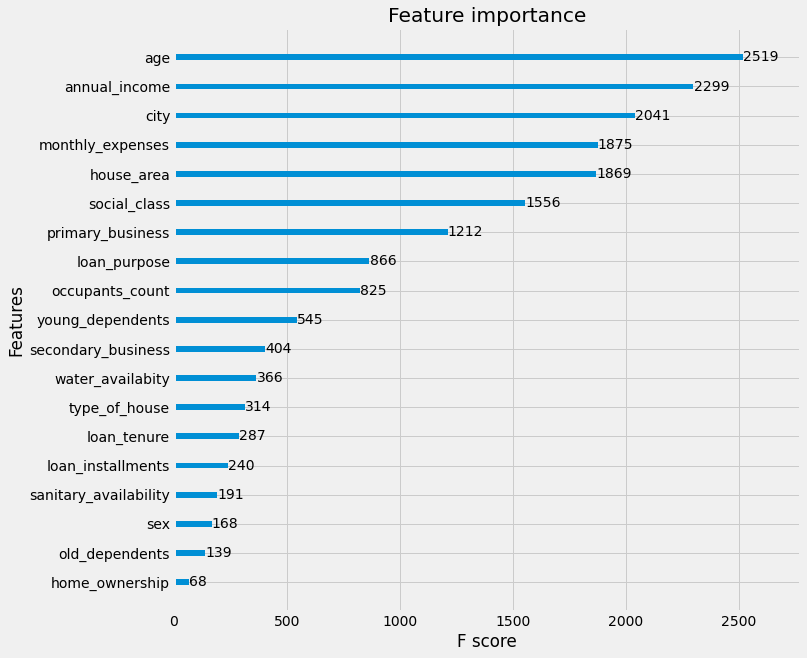

In [219]:
xgb = XGBRegressor(max_depth = 10, random_state = 42)
xgb.fit(df_final_1.loc[:, df_final_1.columns != 'loan_amount'], df_final_1.loan_amount)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
impplot = plot_importance(xgb, ax = ax)
plt.show()

### Check if any missing value remaining in numerical data

In [220]:
total = df_final_1.isnull().sum().sort_values(ascending=False)
percent = (df_final_1.isnull().sum()/df_final_1.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [221]:
missing_data

,Total,Percent
loan_purpose,0,0.0
type_of_house,0,0.0
annual_income,0,0.0
monthly_expenses,0,0.0
old_dependents,0,0.0
young_dependents,0,0.0
home_ownership,0,0.0
occupants_count,0,0.0
house_area,0,0.0
sanitary_availability,0,0.0


### **2.** Replace Missing data with 0

In [226]:
df_final_2 = final_df.copy()

In [227]:
for column in categorical_list:
  df_final_2[column] = df_final_2[column].fillna(0)

In [228]:
for column in categorical_list:
  print(column)
  label_list = df_final_2[column].unique()
  label_value = [i for i in range(len(label_list))]
  dict_label = dict(zip(label_list, label_value))
  mapped_column = map_label(df_final_2[column], dict_label)
  df_final_2.drop(column, axis = 1, inplace = True)
  df_final_2[column] = mapped_column

city
sex
social_class
primary_business
secondary_business
type_of_house
loan_purpose


In [229]:
df_final_2.head()

,age,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,occupants_count,house_area,sanitary_availability,water_availabity,loan_tenure,loan_installments,loan_amount,city,sex,social_class,primary_business,secondary_business,type_of_house,loan_purpose
0,22,36000.0,5000.0,0,2,1.0,4,70.0,1.0,0.5,12,12,5000.0,0,0,0,0,0,0,0
1,21,94000.0,3600.0,1,1,1.0,4,80.0,1.0,0.5,12,50,7500.0,1,0,1,0,1,1,0
2,24,48000.0,4000.0,0,2,1.0,4,50.0,1.0,0.5,12,12,5000.0,0,1,2,1,0,1,1
3,26,7000.0,5000.0,0,2,1.0,5,50.0,1.0,0.5,12,50,7500.0,2,0,1,0,1,1,0
4,23,36000.0,3500.0,0,0,1.0,1,112.0,1.0,0.5,12,12,5000.0,3,0,1,2,2,1,2


[16:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


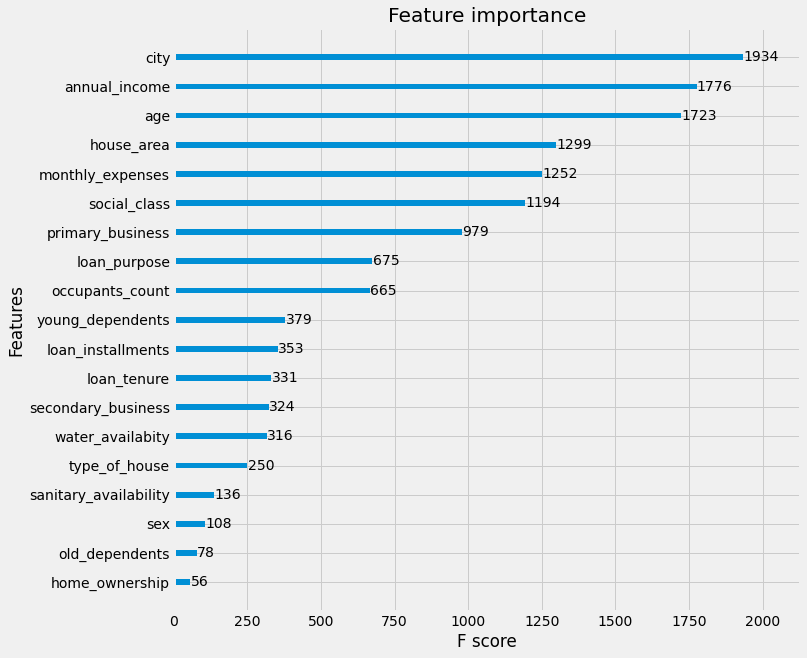

In [230]:
xgb = XGBRegressor(max_depth = 10, random_state = 42)
xgb.fit(df_final_2.loc[:, df_final_2.columns != 'loan_amount'], df_final_2.loan_amount)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
impplot = plot_importance(xgb, ax = ax)
plt.show()

In [231]:
total = df_final_2.isnull().sum().sort_values(ascending=False)
percent = (df_final_2.isnull().sum()/df_final_2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [232]:
missing_data

,Total,Percent
water_availabity,5253,0.131325
home_ownership,379,0.009475
sanitary_availability,208,0.005200
monthly_expenses,120,0.003000
type_of_house,0,0.000000
annual_income,0,0.000000
old_dependents,0,0.000000
young_dependents,0,0.000000
occupants_count,0,0.000000
house_area,0,0.000000


#### From tha above analysis, we can say that out of 4 features - water_availabity, home_ownership, sanitary_availability, monthly_expenses; whoch have missing values, only 1 variable has high importance, i.e., monthly expenses. 

#### To handle missing value, for monthly expenses, let's replace it with linear interpolation and for other 3 replace it with 0.

In [233]:
df_final_2['water_availabity'] = df_final_2['water_availabity'].fillna(0)
df_final_2['home_ownership'] = df_final_2['home_ownership'].fillna(0)
df_final_2['sanitary_availability'] = df_final_2['sanitary_availability'].fillna(0)

df_final_2['monthly_expenses'] = df_final_2['monthly_expenses'].interpolate(method='linear', limit_direction='forward', axis=0)

In [234]:
df_final_2.isnull().values.any()

False

### Divide data into training, testing for Method - 1


In [222]:
loan_amount_1 = df_final_1['loan_amount'].tolist()

In [223]:
df_final_1.drop('loan_amount', axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [224]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_final_1, loan_amount, test_size=0.20, random_state=42)

In [225]:
X_train_1.shape, X_test_1.shape

((26452, 19), (6613, 19))

### Divide data into training, testing for Method - 2


In [188]:
loan_amount_2 = df_final_2['loan_amount'].tolist()

In [189]:
df_final_2.drop('loan_amount', axis = 1, inplace = True)

In [192]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_final_2, loan_amount_2, test_size=0.20, random_state=42)

In [193]:
X_train_2.shape, X_test_2.shape

((32000, 19), (8000, 19))

# **Modeling & Evaluation**

## Linear Regression method - 1

In [238]:
lin_model_1 = LinearRegression().fit(X_train_1, y_train_1)
# define the cross-validation procedure and train using Linear Regression
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lin_model_1, X_train_1, y_train_1, cv=cv, n_jobs=-1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [239]:
# evaluate model
lin_y_pred_1 = lin_model_1.predict(X_test_1)
mse = mean_squared_error(y_test_1, lin_y_pred_1)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))
print("PCC: %.3f" % pearsonr(y_test_1, lin_y_pred_1)[0])

MSE: 216675950.65
RMSE: 108337975.33
PCC: 0.176


## Linear Regression method - 2

In [240]:
lin_model_2 = LinearRegression().fit(X_train_2, y_train_2)
# define the cross-validation procedure and train using Linear Regression
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lin_model_2, X_train_2, y_train_2, cv=cv, n_jobs=-1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [241]:
# evaluate model
lin_y_pred_2 = lin_model_2.predict(X_test_2)
mse = mean_squared_error(y_test_2, lin_y_pred_2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))
print("PCC: %.3f" % pearsonr(y_test_2, lin_y_pred_2)[0])

MSE: 221130801.94
RMSE: 110565400.97
PCC: 0.190


#### Let's analyze why performance of Linear Regression is very less

#### Check how the *loan_amount* is distributed - Let's focus on the target variable (*loan_amount*). Let's create a histogram of the target variable. (Note: As performance of both the methods are same, below analsis is done for only 1 method.)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


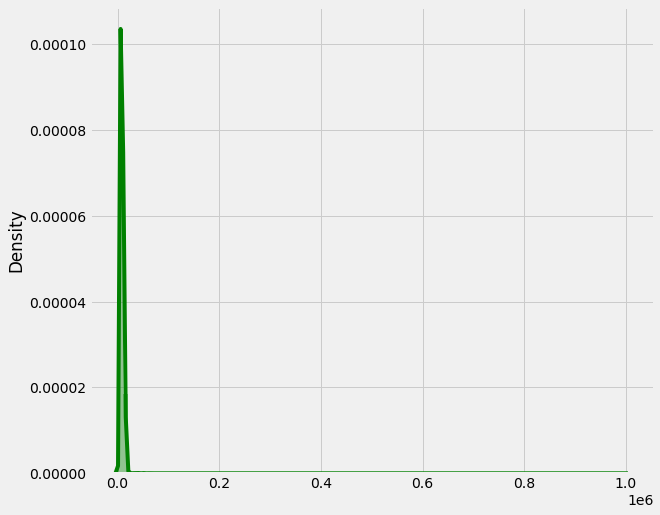

In [242]:
plt.figure(figsize=(9, 8))
sns.distplot(y_train_1, color='g', bins=100, hist_kws={'alpha': 0.4});

####  Target variable is not Normally distributed, it has some amount of skewness. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression.

#### Let's explore more about target variable - relationship between feature and target variable

In [243]:
X_train_column = X_train_1.columns.tolist()

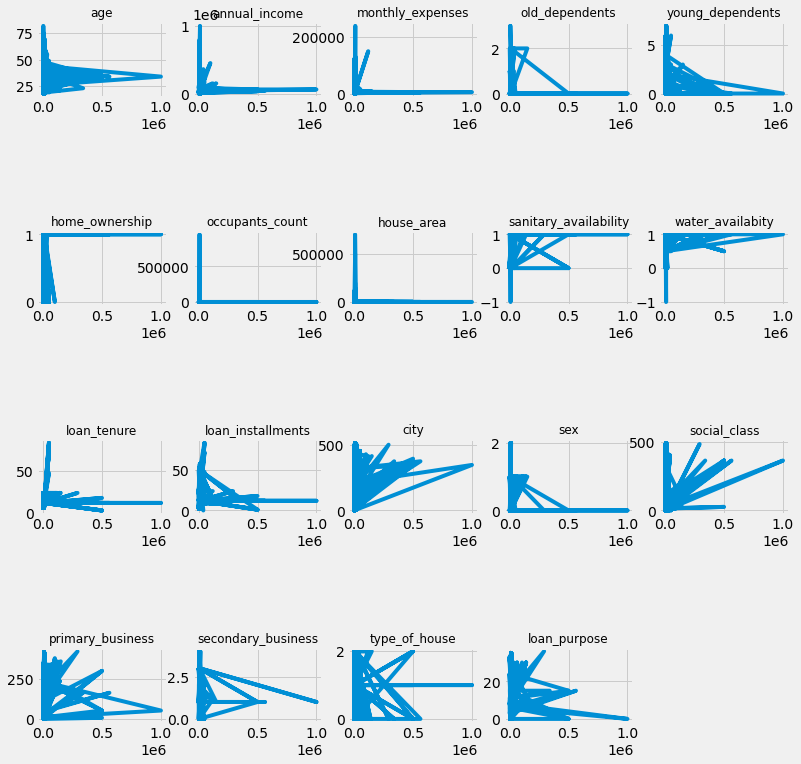

In [244]:
fig = plt.figure(figsize=(12, 12))

fig.subplots_adjust(hspace=1.8, wspace=0.2)

for i in range(1, 20):
    ax = fig.add_subplot(4, 5, i)
    col_name = X_train_column[i-1]
    ax.plot(y_train, X_train_1[col_name])
    ax.set_title(col_name, fontsize=12)

#### From the above diagrams, we can conclude that our target variable shows an unequal level of variance across most predictor (independent) variables, which indicates linear regression model is not an efficient algorithm for this problem.

#### Let's explore quite complex algorithm

## RandomForest for method - 1

In [245]:
ran_frst_model_1 = RandomForestRegressor(max_depth=5, random_state=0)
ran_frst_model_1.fit(X_train_1, y_train_1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [248]:
# evaluate model
rand_y_pred_1 = ran_frst_model_1.predict(X_test_1)
mse = mean_squared_error(y_test_1, rand_y_pred_1)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))
print("PCC: %.3f" % pearsonr(y_test, rand_y_pred)[0])

MSE: 107817910.41
RMSE: 53908955.21
PCC: 0.869


## RandomForest for method - 2

In [249]:
ran_frst_model_2 = RandomForestRegressor(max_depth=5, random_state=0)
ran_frst_model_2.fit(X_train_2, y_train_2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [251]:
# evaluate model
rand_y_pred_2 = ran_frst_model_2.predict(X_test_2)
mse = mean_squared_error(y_test_2, rand_y_pred_2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))
print("PCC: %.3f" % pearsonr(y_test_2, rand_y_pred_2)[0])

MSE: 173246361.89
RMSE: 86623180.95
PCC: 0.527


### From the results of the above algorithm (i.e., RandomForest), we can conlcude that method - 1 is better than method - 2.

## Ensemble Technique

#### Let's use enesemble method to combine the Linear Regression and RandomForest for method - 1.

In [ ]:
finalpred = (lin_y_pred_1 + rand_y_pred_1) / 2

In [252]:
# evaluate model
mse = mean_squared_error(y_test_1, finalpred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))
print("PCC: %.3f" % pearsonr(y_test_1, finalpred)[0])

MSE: 154540668.85
RMSE: 77270334.42
PCC: 0.820


#### From the above result, we can conclude that because of poor performance of Linear Regression (here, it is weak classifier), in ensemble technique we did not get higher performance comapred to both the models.

#### So, it is better to go for another strong algorithm compared to Ensemble technique. (Note: As we have seen method - 1 is working better comapred to method - 2, but it is always good to check new algorithm for both the methods. So, we are going to explore new algorithm for both the methods.)

## XGBoost for method - 1

In [255]:
xgbr_model_1 = xgb.XGBRegressor(verbosity=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

xgbr_model_1.fit(X_train_1, y_train_1)

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr_model_1, X_train_1, y_train_1, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.37


In [259]:
# evaluate model
xgbr_y_pred_1 = xgbr_model_1.predict(X_test_1)
mse = mean_squared_error(y_test_1, xgbr_y_pred_1)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))
print("PCC: %.3f" % pearsonr(y_test_1, xgbr_y_pred_1)[0])

MSE: 72398991.89
RMSE: 36199495.95
PCC: 0.932


## XGBoost for method - 2

In [260]:
xgbr_model_2 = xgb.XGBRegressor(verbosity=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

xgbr_model_2.fit(X_train_2, y_train_2)

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr_model_2, X_train_2, y_train_2, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.49


In [261]:
# evaluate model
xgbr_y_pred_2 = xgbr_model_2.predict(X_test_2)
mse = mean_squared_error(y_test_2, xgbr_y_pred_2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))
print("PCC: %.3f" % pearsonr(y_test_2, xgbr_y_pred_2)[0])

MSE: 281576684.97
RMSE: 140788342.49
PCC: 0.429


#### From the above algorithm, we can conclude that data we have created using method - 1 is more efficient way compared to method - 2.

#### Conclusion - As we have large amount of data, i.e., 40000, in which 6935 datapoints have missing value/NaN value; removng these data is better compare to replace it with any other value. Because sometimes it may happen that because of replaced value (which is not 100% true data) model can interpret data wrongly or replaced value may introduce outliers in data.

#### Plot the original data and predicted data

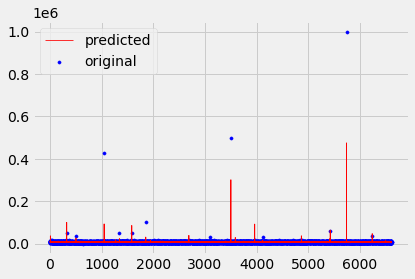

In [262]:
x_ax = range(len(y_test_1))
plt.scatter(x_ax, y_test_1, s=10, color="blue", label="original")
plt.plot(x_ax, xgbr_y_pred_1, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()